In [3]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize

In [4]:
import matplotlib.pyplot as plt

# Importation des valeurs

In [5]:
alpha = 0.15
b = 1
sigma = 0.2
T = 1
r = 0.05
K = 4
k = 20
dt = 1/20
S_0 = 5 #le fixer à 1 si on veut obtenir les cheveux 

# Test du CIR 

In [6]:
import CIR

In [7]:
S = CIR.CIR(alpha, b, sigma, T, k, S_0)

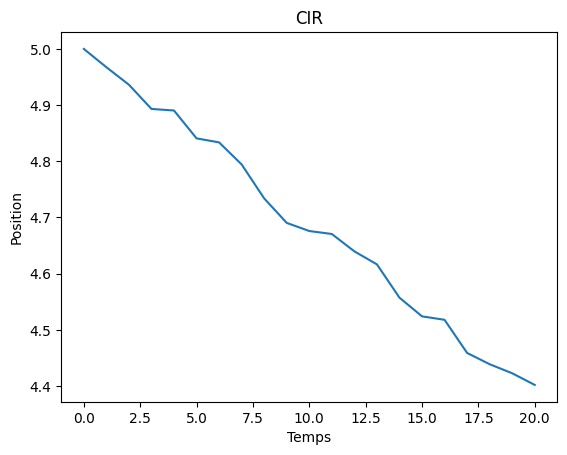

In [8]:
plt.plot(S)
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('CIR')
plt.show()

In [9]:
nb_samples = 100

In [10]:
M = CIR.multiCIR(alpha, b, sigma, T, k, S_0, nb_samples)

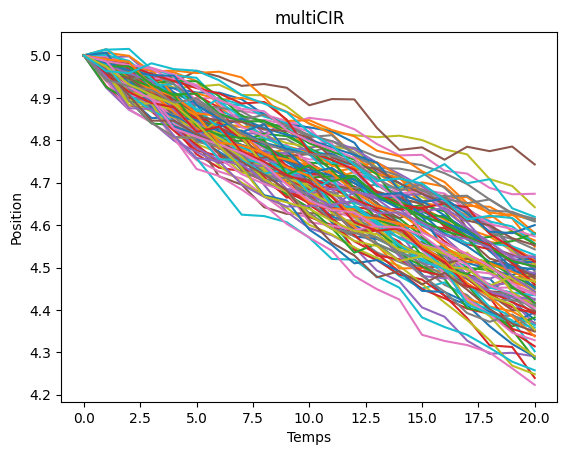

In [11]:
for i in range(nb_samples):
    plt.plot(M[i])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('multiCIR')
plt.show()

# Monte Carlo Ordinaire

In [12]:
import ordinaryMC

In [13]:
ordinaryMC.pv_calc(M[3],r, T)

array([4.75614712, 4.68658666, 4.64406489, 4.63771895, 4.5951162 ,
       4.53447556, 4.50425069, 4.49681318, 4.47471417, 4.45559678,
       4.42847315, 4.41980611, 4.41293889, 4.39583511, 4.36233375,
       4.38254579, 4.3393276 , 4.30382079, 4.28284427, 4.25535204,
       4.26617463])

In [14]:
OMC = ordinaryMC.ordinary_mc_sim(nb_samples, k, S_0, T, r, sigma, K, alpha, b)

In [15]:
np.mean(OMC)

0.6727664297377234

In [16]:
ordinaryMC.sim_iterator(1000, k, S_0, T, r, sigma, K, alpha, b)

array([0.65730802, 0.68835983, 0.68431098, 0.67166767, 0.68413804,
       0.66900252, 0.68471681, 0.68316262, 0.67684475, 0.67400083,
       0.66792121, 0.67714216, 0.67480694, 0.67827181, 0.68683032,
       0.68289095, 0.67849418, 0.6763242 , 0.67759386, 0.6780131 ,
       0.67790011, 0.67689011, 0.68337065, 0.67655027, 0.67973931,
       0.67898049, 0.6871346 , 0.6807176 , 0.67210875, 0.67884515,
       0.68172784, 0.6808959 , 0.67475886, 0.6782858 , 0.67552321,
       0.6754168 , 0.67996616, 0.67729753, 0.68124719, 0.6802371 ,
       0.67965251, 0.68369161, 0.6778061 , 0.68071613, 0.67727967,
       0.67806591, 0.67948971, 0.67411809, 0.67889505, 0.67739993,
       0.67767344, 0.67308729, 0.67738836, 0.67981159, 0.67589477,
       0.68096918, 0.67921423, 0.68056232, 0.67875411, 0.67649135,
       0.67931278, 0.67926324, 0.67967646, 0.67742899, 0.68011104,
       0.68495148, 0.67745985, 0.68273781, 0.67847063, 0.67705687,
       0.68021087, 0.68184886, 0.6788293 , 0.67512721, 0.67813

# Quasi Monte Carlo

# tests Sobol generator

In [17]:
nb_samples = 100

In [18]:
sobol = CIR.sobol_generator(nb_samples, k)
print(sobol, len(sobol), len(sobol[1,]))

[[0.5     0.75    0.25    ... 0.84375 0.34375 0.46875]
 [0.5     0.25    0.75    ... 0.21875 0.71875 0.09375]
 [0.5     0.75    0.25    ... 0.09375 0.59375 0.46875]
 ...
 [0.75    0.25    0.875   ... 0.53125 0.15625 0.65625]
 [0.75    0.25    0.375   ... 0.09375 0.21875 0.71875]
 [0.75    0.25    0.125   ... 0.78125 0.65625 0.15625]] 117 20


# tests CIR_QMC

In [19]:
M = CIR.multiCIR_QMC(alpha, b, sigma, T, k, S_0, nb_samples)

In [20]:
M

[array([5.        , 5.03744898, 4.93946701, 4.87825054, 4.96278943,
        4.96481366, 4.8204481 , 4.70468753, 4.72431463, 4.84550502,
        4.8011776 , 4.72477279, 4.78307542, 4.77008839, 4.5919693 ,
        4.43872077, 4.43527959, 4.50463955, 4.44017429, 4.40698374,
        4.55630972]),
 array([5.        , 4.90255102, 4.94007035, 4.87884742, 4.96338878,
        4.81905036, 4.82168952, 4.74502866, 4.80336404, 4.62447364,
        4.61241889, 4.50011885, 4.52023797, 4.47887887, 4.59798478,
        4.56348048, 4.71471071, 4.61145578, 4.63998739, 4.48572004,
        4.48204437]),
 array([5.        , 5.03744898, 4.93946701, 4.94159148, 4.79766848,
        4.7379734 , 4.82191875, 4.74525503, 4.80359077, 4.79048284,
        4.61189081, 4.73213936, 4.68884442, 4.57526817, 4.59520925,
        4.66506957, 4.59872715, 4.44533503, 4.44186089, 4.40865629,
        4.5580029 ]),
 array([5.        , 4.90255102, 4.94007035, 4.79617636, 4.79891276,
        4.73920429, 4.82315496, 4.84248678, 4.7263

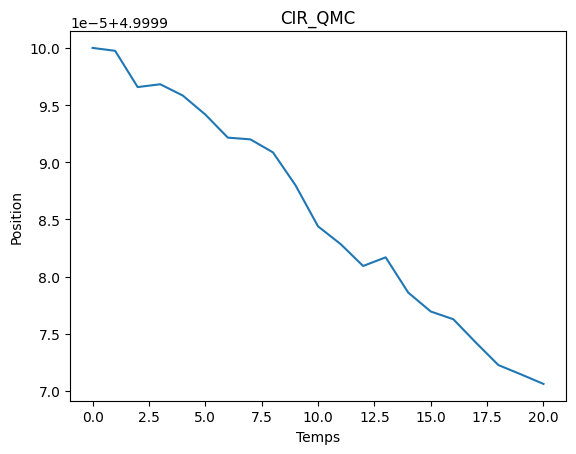

In [43]:
plt.plot(M[1])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('CIR_QMC')
plt.show()

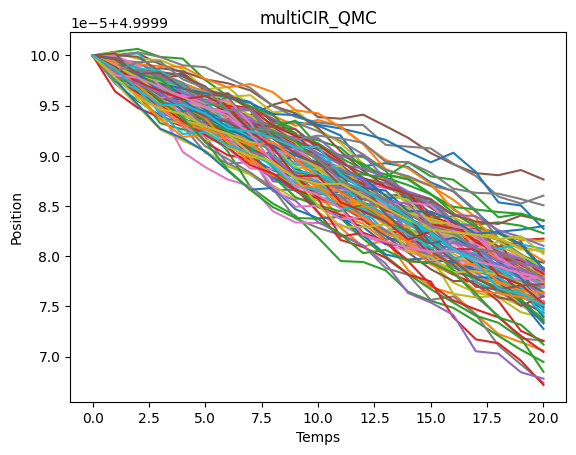

In [46]:
for i in range(nb_samples):
    plt.plot(M[i])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('multiCIR_QMC')
plt.show()

# Quasi Monte Carlos

In [23]:
import ordinaryMC
import QMC

In [24]:
ordinaryMC.pv_calc(M[3],r, T)

array([4.75614712, 4.66345079, 4.69914028, 4.56226408, 4.56486702,
       4.50807057, 4.58792692, 4.60631592, 4.49585464, 4.61115062,
       4.56896722, 4.55650063, 4.38662669, 4.44190474, 4.37079301,
       4.3235163 , 4.41775917, 4.2991677 , 4.31043676, 4.23279869,
       4.27786066])

In [25]:
OMC_QMC = QMC.QMC_mc_sim(nb_samples, k, S_0, T, r, sigma, K, alpha, b)
np.mean(OMC_QMC)

0.6729958803021122

In [26]:
QMC.sim_iterator_QMC(1000, k, S_0, T, r, sigma, K, alpha, b)

array([0.67030405, 0.66890891, 0.67289144, 0.67368627, 0.67307766,
       0.67222133, 0.67397267, 0.67343756, 0.67302825, 0.67299588,
       0.67232377, 0.67187278, 0.67152841, 0.67126818, 0.67215052,
       0.67281187, 0.67259377, 0.67073935, 0.67169282, 0.67153946,
       0.67227589, 0.67190686, 0.67178969, 0.67184999, 0.67205816,
       0.67217644, 0.67262645, 0.67164796, 0.67172295, 0.67181705,
       0.67182892, 0.67229061, 0.6728063 , 0.67348223, 0.67445719,
       0.67504915, 0.67634998, 0.67519357, 0.67572613, 0.6758411 ,
       0.67625629, 0.67650668, 0.67647068, 0.6763089 , 0.67627988,
       0.67621747, 0.67684416, 0.67628533, 0.67630456, 0.67596895,
       0.67577944, 0.67526663, 0.6755823 , 0.67539858, 0.67540742,
       0.67461142, 0.67503888, 0.67527696, 0.67473238, 0.67455601,
       0.67449193, 0.67466979, 0.67458252, 0.67376248, 0.67401107,
       0.67360358, 0.67293898, 0.67269142, 0.67246486, 0.67160056,
       0.67168216, 0.67152864, 0.67133645, 0.67140572, 0.67192

# tests Multi CIR

In [27]:
L = 20

In [28]:
S = CIR.CIR_ML(alpha, b, sigma, T, k, S_0, L)

In [29]:
S

array([5.        , 5.00000001, 4.99999862, 4.99999656, 4.99999458,
       4.99999375, 4.99999262, 4.9999909 , 4.99998956, 4.99998868,
       4.99998626, 4.99998529, 4.99998456, 4.99998363, 4.99998156,
       4.99998139, 4.99998115, 4.99998028, 4.99997853, 4.99997774,
       4.99997749])

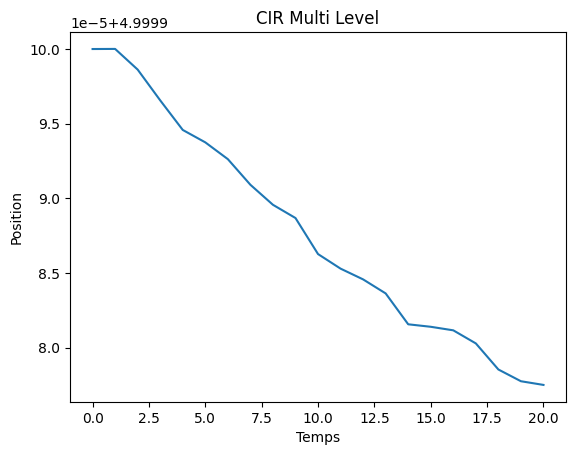

In [30]:
plt.plot(S)
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('CIR Multi Level')
plt.show()

In [31]:
nb_samples = 100 

In [32]:
M = CIR.multiCIR_ML(alpha, b, sigma, T, k, S_0, nb_samples, L)

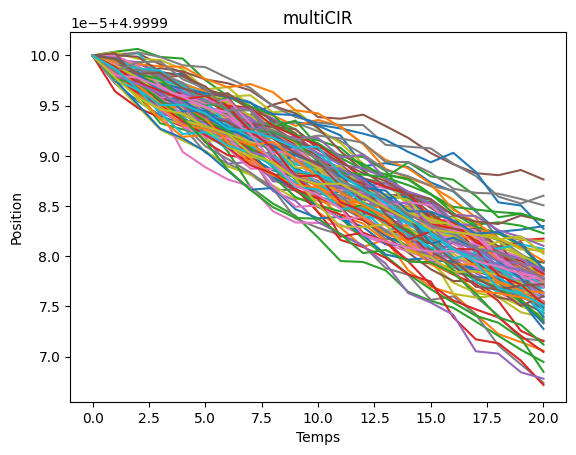

In [33]:
for i in range(nb_samples):
    plt.plot(M[i])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('multiCIR')
plt.show()

In [34]:
zap = CIR.CIR(alpha, b, sigma, T, k, S_0)
zap2 = CIR.CIR_ML(alpha, b, sigma, T, k, S_0,1)

In [35]:
zap

array([5.        , 4.99738058, 4.95192243, 4.91861012, 4.89405524,
       4.84803828, 4.81970221, 4.77924691, 4.75961936, 4.7072049 ,
       4.65963159, 4.59150924, 4.58941811, 4.52519576, 4.47204343,
       4.42079052, 4.3958768 , 4.40302904, 4.37751284, 4.3699722 ,
       4.36576904])

In [36]:
zap2

array([5.        , 4.76473796, 4.29236206, 4.37292651, 3.1020969 ,
       2.78815256, 2.33127089, 2.13926703, 2.34468536, 1.78838399,
       1.33236301, 0.99518356, 1.44081748, 1.14062737, 0.76217218,
       0.71038042, 0.82646908, 0.97367931, 0.8427115 , 0.94269056,
       0.82440551])

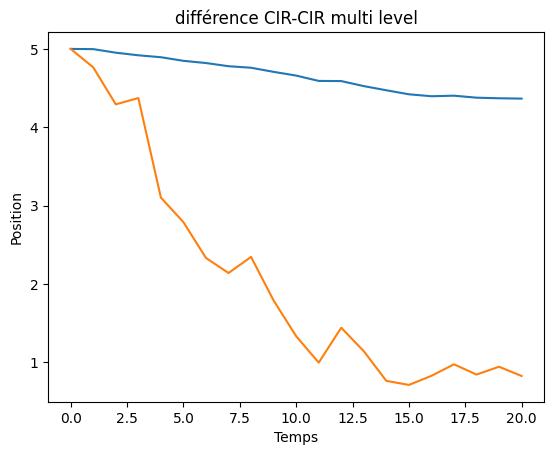

In [37]:
plt.plot(zap)
plt.plot(zap2)
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('différence CIR-CIR multi level')
plt.show()

# Multi Level Monte Carlo

In [38]:
import MLMC

In [39]:
variance = np.full(14, 1)  
k = 20
T = 1
l = 0
L = 0
epsilon = np.exp(-1)

In [40]:
CIR.CIR_ML(alpha, b, sigma, T, k, S_0, L)

array([5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [41]:
MLMC.N_l(variance, k, T,l, L, epsilon)

0
0.0


0

In [42]:
N

NameError: name 'N' is not defined

In [ ]:
MLMC_test = MLMC.sim_MLMC(k, S_0, T, r, sigma, K, alpha, b)